# 读取数据

以广西南宁某水电站 2015 年 5 月投入使用的额定功率为 30.77MW 的灯泡贯流式水电机组为研究对象，该水电站计算机监控系统中存储了自运行以来的大量水电机组运行状态监测数据。监控系统采集的监测参数包括电流、电压、功率等电气参数，振动、行程、位移、导叶开度、水位、流量、压力等机械参数，以及瓦温、油温、绕组温度等热量参数，主要测点的部分原始数据见表 1。在实际中，由于传感器异常、机组停机、日常维修等问题会导致存储的数据存在丢失、奇异等问题，在对数据分析之前需要对原始数据进行清洗。

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.cluster import KMeans
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [2]:
data = pd.read_csv("../data/离群数据.csv", encoding="gbk")
data.to_pickle("../data/离群数据.pkl")
data.head(5)

,时间,机组有功负荷MW,定子线棒温度℃,标签
0,2023.09.17 00:00,14.85,24.39,1
1,2023.09.17 00:01,11.24,16.86,1
2,2023.09.17 00:02,13.42,18.70,1
3,2023.09.17 00:03,15.43,24.06,1
4,2023.09.17 00:04,22.70,30.79,1


In [131]:
#选择合适的数据
data = data.iloc[:,1:].values

# 数据分析

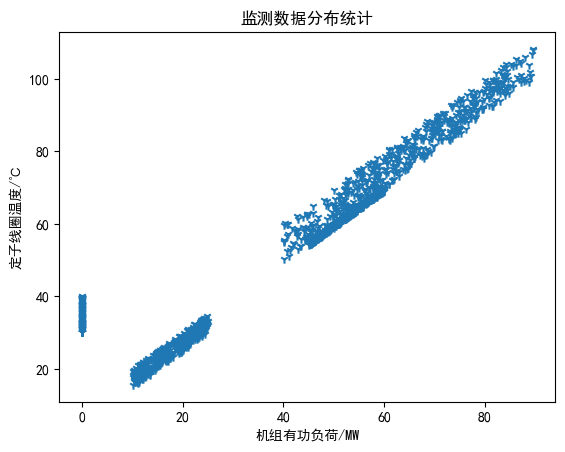

In [4]:
plt.scatter(x=data[:, 0], y=data[:, 1], marker='1')
plt.title("监测数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/监测数据分布统计.png", dpi=600)
plt.show()

## 直方图

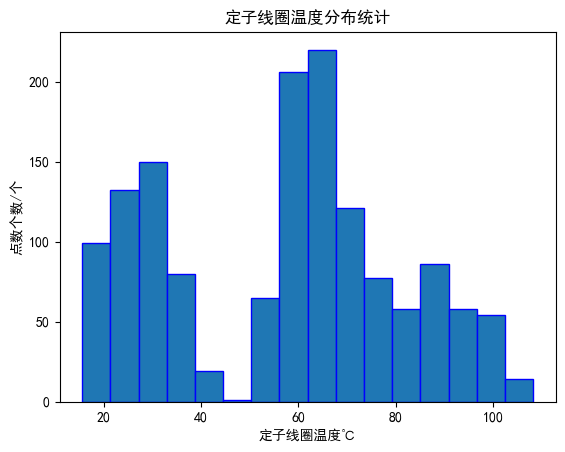

In [5]:
plt.hist(data[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.savefig("../image/定子线圈温度分布统计.png", dpi=600)
plt.show()

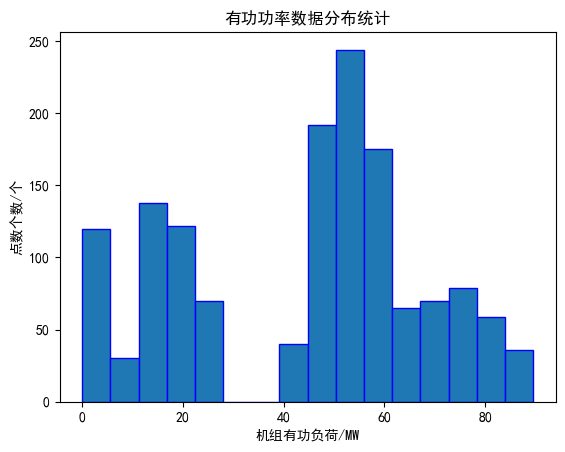

In [6]:
plt.hist(data[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.savefig("../image/有功功率数据分布统计.png", dpi=600)
plt.show()

## 箱线图

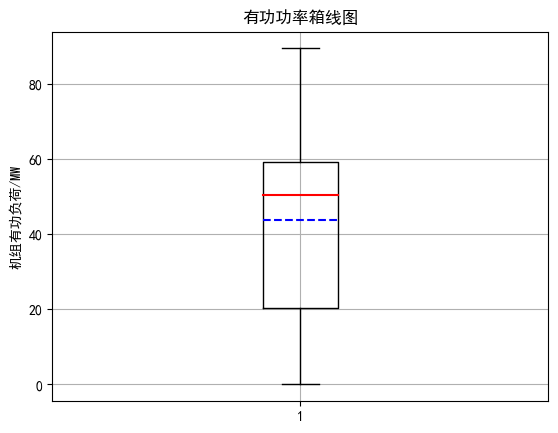

In [7]:
plt.grid(True)  # 显示网格
plt.boxplot(data[:, 0],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},)
plt.title("有功功率箱线图")
plt.ylabel("机组有功负荷/MW")
plt.savefig("../image/有功功率箱线图.png", dpi=600)
plt.show()

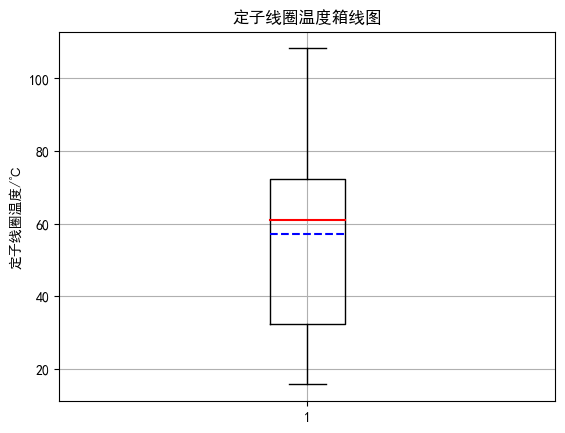

In [8]:
plt.grid(True)  # 显示网格
plt.boxplot(data[:, 1],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},)
plt.title("定子线圈温度箱线图")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/定子线圈温度箱线图.png", dpi=600)
plt.show()

In [9]:
# train, test = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
# X_train = train.iloc[:,1:3].values
# Y_train = train.iloc[:,-1].values
# X_test = test.iloc[:,1:3].values
# Y_test = test.iloc[:,-1].values

# 异常检测

## KNN

In [90]:
# 训练一个kNN检测器
clf_name = 'kNN'
clf = KNN(n_neighbors=30) # 初始化检测器clf
clf.fit(data) # 使用X_train训练检测器clf
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
# 用训练好的clf来预测未知数据中的异常值
# y_test_pred = clf.predict(X_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
# y_test_scores = clf.decision_function(X_test)  #  返回未知数据上的异常值 (分值越大越异常)

In [91]:
#区分聚类数
labels = y_train_pred
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values

C:\Users\IKAS\AppData\Local\Temp\ipykernel_18744\51841524.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', cmap='rainbow')


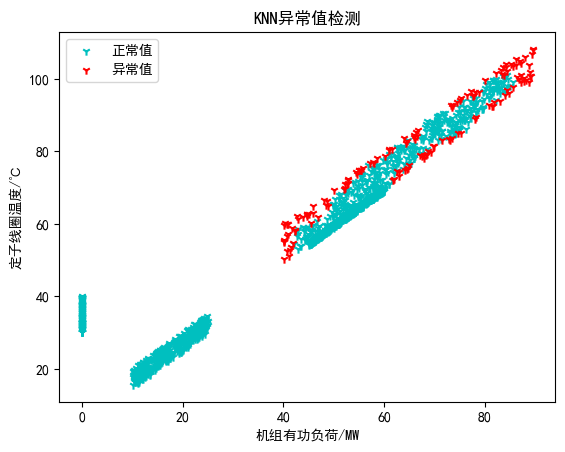

In [92]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend(["正常值", "异常值"])
plt.title("KNN异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/KNN异常值检测.png", dpi=600)
plt.show()

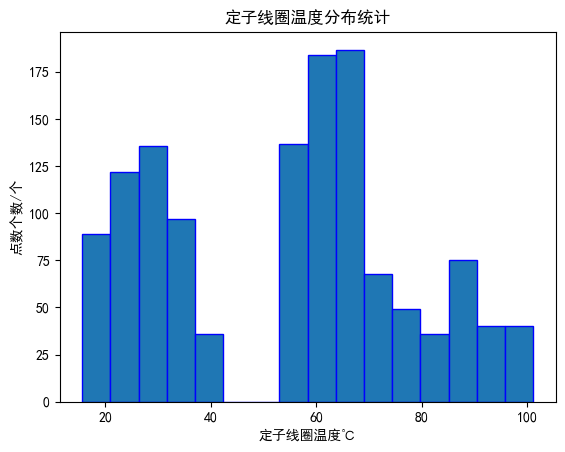

In [14]:
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1]
id_data.to_pickle("../data/knn.pkl")
plt.hist(id_data.iloc[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.show()

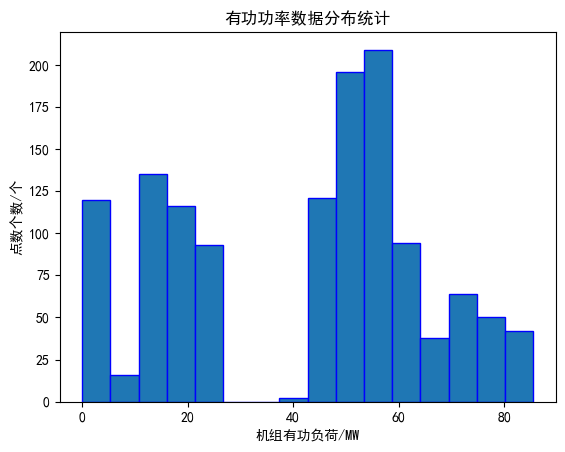

In [15]:
plt.hist(id_data.iloc[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

In [16]:
knn_res = np.where(y_train_pred == 1)

In [17]:
len(knn_res[0])

144

## IsolationForest

In [18]:
# 训练一个IForest检测器
clf_name = 'IForest'
clf = IForest() # 初始化检测器clf
clf.fit(data) # 使用X_train训练检测器clf
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
# 用训练好的clf来预测未知数据中的异常值
# y_test_pred = clf.predict(X_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
# y_test_scores = clf.decision_function(X_test)  #  返回未知数据上的异常值 (分值越大越异常)

In [19]:
#区分聚类数
labels = y_train_pred
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values

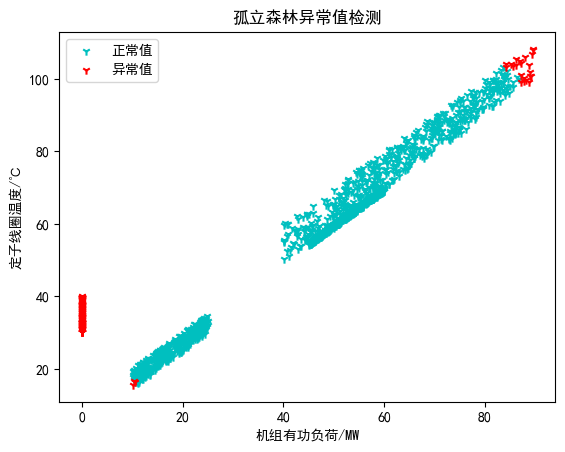

In [20]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend(["正常值", "异常值"])
plt.title("孤立森林异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/孤立森林异常值检测.png", dpi=600)
plt.show()

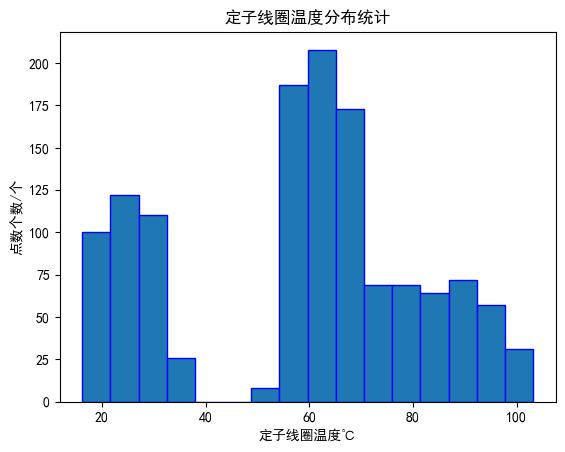

In [21]:
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1]
id_data.to_pickle("../data/iforest.pkl")
plt.hist(id_data.iloc[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.show()

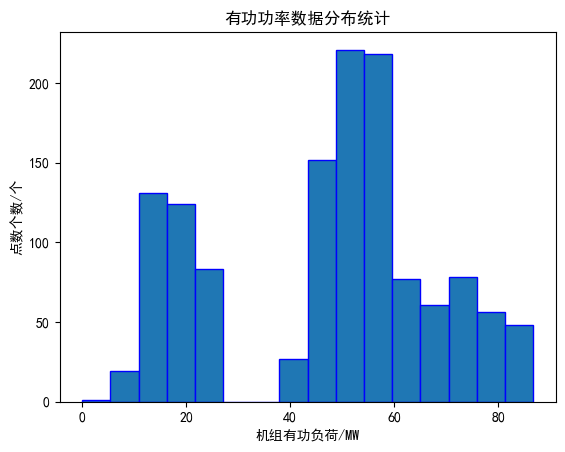

In [22]:
plt.hist(id_data.iloc[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

In [23]:
iforest_res = np.where(y_train_pred == 1)

In [24]:
len(iforest_res[0])

144

## LOF

In [25]:
# 训练一个LOF检测器
clf_name = 'LOF'
clf = LOF(n_neighbors=70) # 初始化检测器clf
clf.fit(data) # 使用X_train训练检测器clf
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
# 用训练好的clf来预测未知数据中的异常值
# y_test_pred = clf.predict(X_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
# y_test_scores = clf.decision_function(X_test)  #  返回未知数据上的异常值 (分值越大越异常)

In [26]:
#区分聚类数
labels = y_train_pred
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values

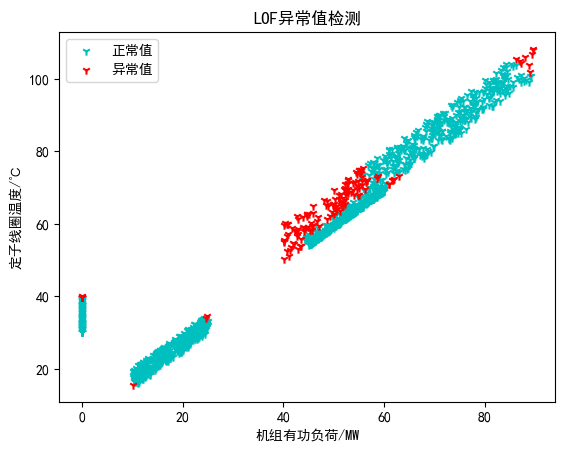

In [27]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend(["正常值", "异常值"])
plt.title("LOF异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/LOF异常值检测.png", dpi=600)
plt.show()

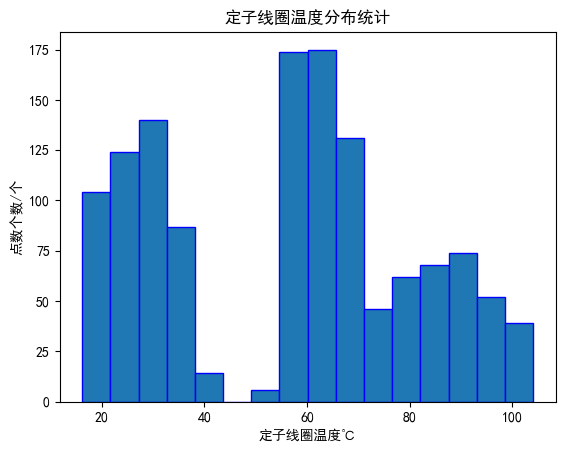

In [28]:
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1]
id_data.to_pickle("../data/lof.pkl")
plt.hist(id_data.iloc[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.show()

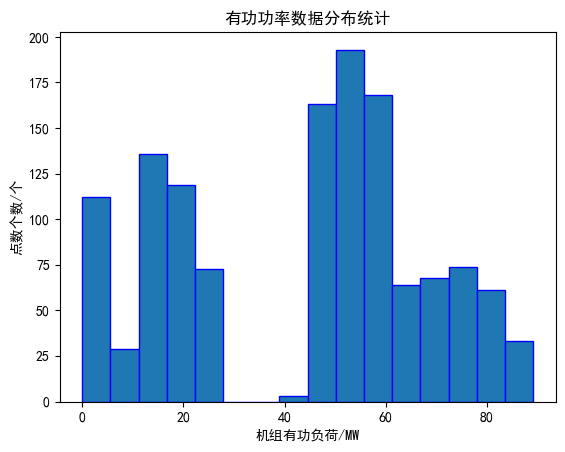

In [29]:
plt.hist(id_data.iloc[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

In [30]:
lof_res = np.where(y_train_pred == 1)

In [31]:
len(lof_res[0])

144

## OCSVM

In [137]:
# 训练一个OCSVM检测器
clf_name = 'OCSVM'
clf = OCSVM(kernel='linear', degree=3) # 初始化检测器clf
clf.fit(data) # 使用X_train训练检测器clf
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
# 用训练好的clf来预测未知数据中的异常值
# y_test_pred = clf.predict(X_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
# y_test_scores = clf.decision_function(X_test)  #  返回未知数据上的异常值 (分值越大越异常)

In [143]:
#区分聚类数
labels = y_train_pred
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values

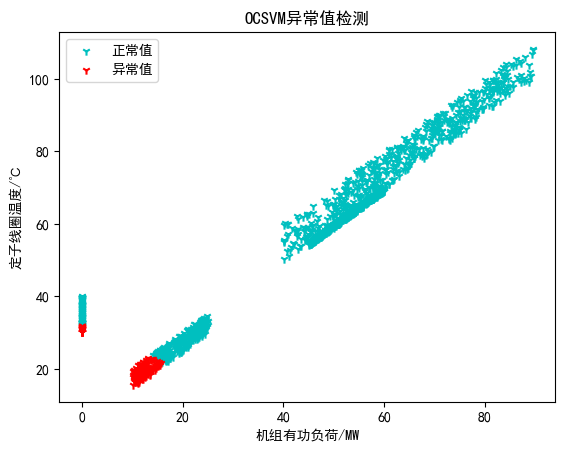

In [144]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend(["正常值", "异常值"])
plt.title("OCSVM异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/OCSVM异常值检测.png", dpi=600)
plt.show()

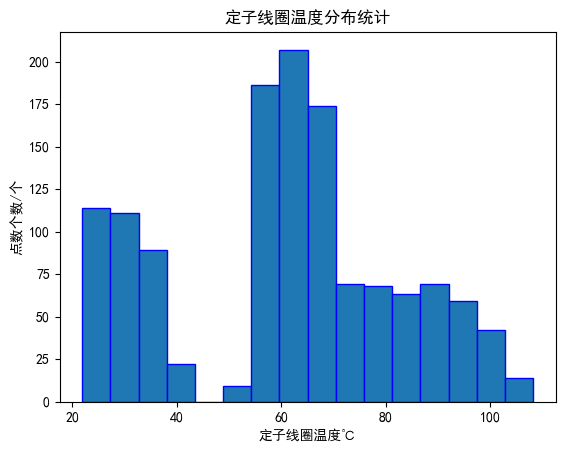

In [35]:
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1]
id_data.to_pickle("../data/ocsvm.pkl")
plt.hist(id_data.iloc[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.show()

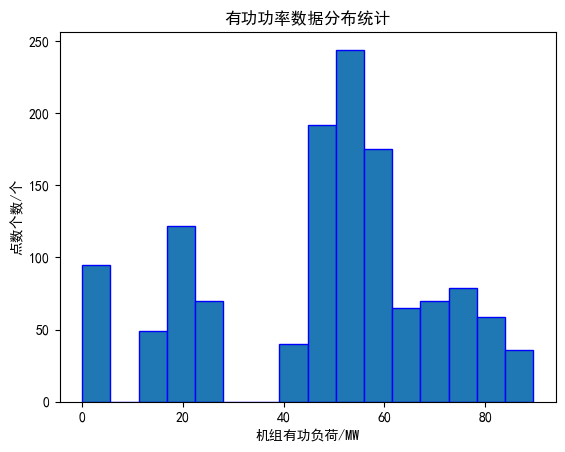

In [36]:
plt.hist(id_data.iloc[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

In [37]:
ocsvm_res = np.where(y_train_pred == 1)

In [38]:
len(ocsvm_res[0])

144

# 聚类分析

## Kmeans获取最佳聚类数

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

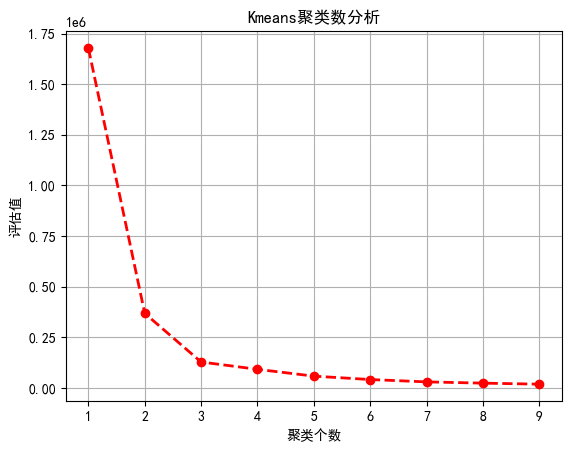

In [39]:
#使用SSE进行模型评估,
sse=[]
for i in range(1,10):
    cluster=KMeans(n_clusters=i,random_state=0, n_init= 'auto').fit(data[:,:-1])
    inertia=cluster.inertia_
    sse.append(inertia)
plt.plot(range(1,10),sse,color='red',linewidth=2.0,linestyle='--',marker='o',label='sse')
plt.grid(True)
plt.title("Kmeans聚类数分析")
plt.xlabel("聚类个数")
plt.ylabel("评估值")
plt.savefig("../image/Kmeans聚类数分析.png", dpi=600)
plt.show()

## 2个聚类中心

In [40]:
cluster=KMeans(n_clusters=2, random_state=0, n_init= 'auto').fit(data[:,:-1])
centers=cluster.cluster_centers_

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [41]:
#区分聚类数
labels = cluster.labels_
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] != 1].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values

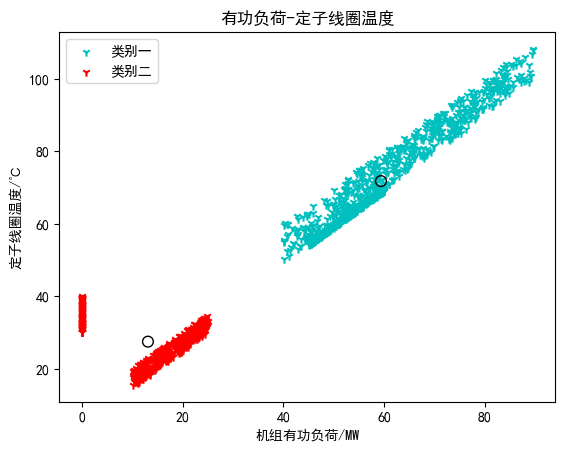

In [42]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.scatter(x=centers[:, 0], y=centers[:, 1], s=60, marker='o', facecolors='none', edgecolors='black')
plt.legend(["类别一", "类别二"])
plt.title("有功负荷-定子线圈温度")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/有功负荷-定子线圈温度-2个聚类中心.png", dpi=600)
plt.show()

## 3个聚类中心

In [43]:
cluster=KMeans(n_clusters=3, random_state=0, n_init= 'auto').fit(data[:,:-1])
centers=cluster.cluster_centers_

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [44]:
#区分聚类数
labels = cluster.labels_
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] == 0].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values
pd_data = od_id_data[od_id_data.iloc[:,-1] == 2].values

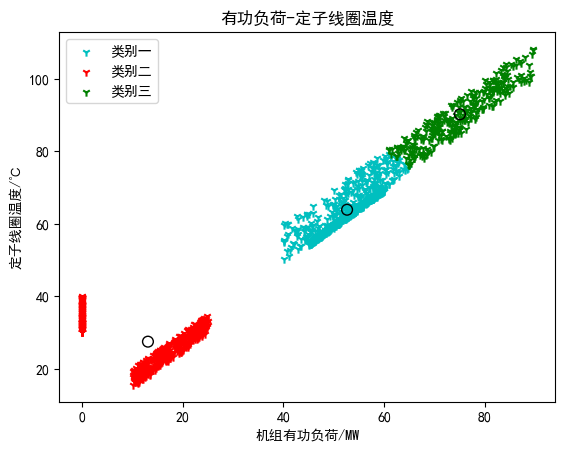

In [45]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.scatter(x=pd_data[:, 0], y=pd_data[:, 1], c='g', marker='1', )
plt.scatter(x=centers[:, 0], y=centers[:, 1], s=60, marker='o', facecolors='none', edgecolors='black')
plt.legend(["类别一", "类别二", "类别三"])
plt.title("有功负荷-定子线圈温度")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/有功负荷-定子线圈温度-3个聚类中心.png", dpi=600)
plt.show()

## 4个聚类中心

In [46]:
cluster=KMeans(n_clusters=4, random_state=0, n_init= 'auto').fit(data[:,:-1])
centers=cluster.cluster_centers_

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [47]:
#区分聚类数
labels = cluster.labels_
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] == 0].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values
pd_data = od_id_data[od_id_data.iloc[:,-1] == 2].values
qd_data = od_id_data[od_id_data.iloc[:,-1] == 3].values

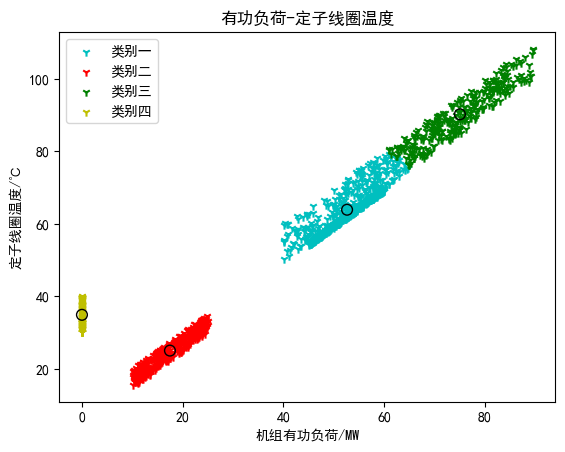

In [48]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.scatter(x=pd_data[:, 0], y=pd_data[:, 1], c='g', marker='1', )
plt.scatter(x=qd_data[:, 0], y=qd_data[:, 1], c='y', marker='1', )
plt.scatter(x=centers[:, 0], y=centers[:, 1], s=60, marker='o', facecolors='none', edgecolors='black')
plt.legend(["类别一", "类别二", "类别三", "类别四"])
plt.title("有功负荷-定子线圈温度")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/有功负荷-定子线圈温度-4个聚类中心.png", dpi=600)
plt.show()

## 5个聚类中心

In [49]:
cluster=KMeans(n_clusters=5, random_state=0, n_init= 'auto').fit(data[:,:-1])
centers=cluster.cluster_centers_

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [50]:
#区分聚类数
labels = cluster.labels_
y_train_pred = labels[:,np.newaxis]
od_id_data = pd.DataFrame(np.concatenate([data, y_train_pred], axis=1))
id_data = od_id_data[od_id_data.iloc[:,-1] == 0].values
od_data = od_id_data[od_id_data.iloc[:,-1] == 1].values
pd_data = od_id_data[od_id_data.iloc[:,-1] == 2].values
qd_data = od_id_data[od_id_data.iloc[:,-1] == 3].values
rd_data = od_id_data[od_id_data.iloc[:,-1] == 4].values

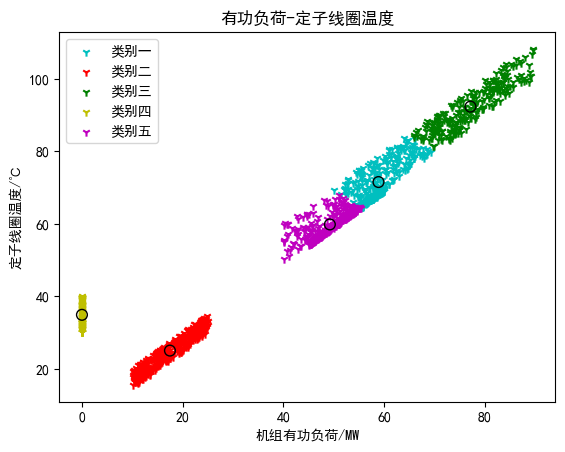

In [51]:
plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.scatter(x=pd_data[:, 0], y=pd_data[:, 1], c='g', marker='1', )
plt.scatter(x=qd_data[:, 0], y=qd_data[:, 1], c='y', marker='1', )
plt.scatter(x=rd_data[:, 0], y=rd_data[:, 1], c='m', marker='1', )
plt.scatter(x=centers[:, 0], y=centers[:, 1], s=60, marker='o', facecolors='none', edgecolors='black')
plt.legend(["类别一", "类别二", "类别三", "类别四", "类别五"])
plt.title("有功负荷-定子线圈温度")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.savefig("../image/有功负荷-定子线圈温度-5个聚类中心.png", dpi=600)
plt.show()

# 对比检测效果

In [52]:
#四种异常检测相同异常值
m = 0
index = []
for i in knn_res[0]:
    for j in ocsvm_res[0]:
        for k in lof_res[0]:
            for l in iforest_res[0]:
                if i == j == k == l:
                    index.append(i)
                    m += 1
            
print("相同异常值：{0}组".format(m))
print(index)

相同异常值：0组
[]


In [88]:
knn_ds = pd.DataFrame([0]*len(data), columns=["knn"])
knn_ds.iloc[list(knn_res[0]), :] = 1
ocsvm_ds = pd.DataFrame([0]*len(data), columns=["ocsvm"])
ocsvm_ds.iloc[list(ocsvm_res[0]), :] = 1
lof_ds = pd.DataFrame([0]*len(data), columns=["lof"])
lof_ds.iloc[list(lof_res[0]), :] = 1
iforest_ds = pd.DataFrame([0]*len(data), columns=["iforest"])
iforest_ds.iloc[list(iforest_res[0]), :] = 1
comp_res = pd.concat([knn_ds, ocsvm_ds, lof_ds, iforest_ds], axis=1)

In [89]:
comp_res

,knn,ocsvm,lof,iforest
0,0,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1435,0,0,1,0
1436,0,0,1,0
1437,0,0,0,0
1438,0,0,0,0


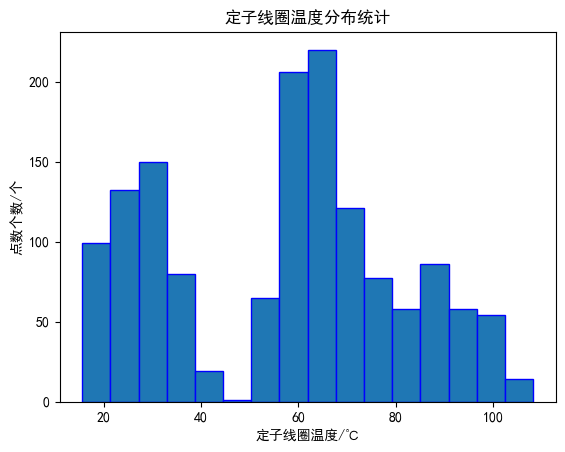

In [55]:
inindex = list(set([i for i in range(len(data))]) - set(index))
id_data = pd.DataFrame(data).iloc[inindex,:]
id_data.to_pickle("../data/compare.pkl")
plt.hist(id_data.iloc[:,1], bins=16, edgecolor="b")
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度/℃")
plt.ylabel("点数个数/个")
plt.show()

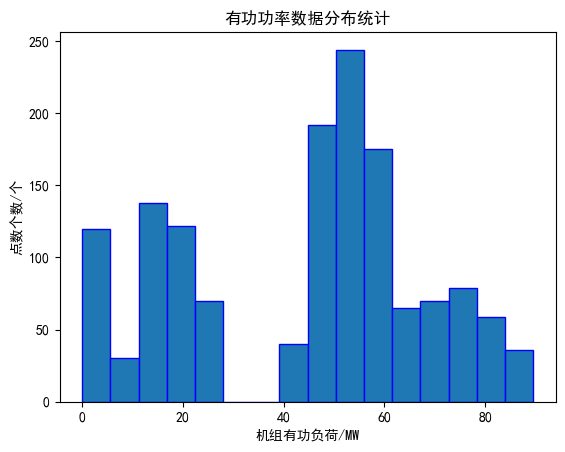

In [56]:
plt.hist(id_data.iloc[:,0], bins=16, edgecolor="b")
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

# 删除错误数据

因机组在停机状态，监控系统在正常运行，此时生成的数据中功率接近于 0，这些数据对机组分析评估没有意义。因此，剔除数据中有功功率接近于 0 且机组转速为 0的记录。

In [57]:
final_data = id_data[id_data.iloc[:,0] != 0]
final_data.to_pickle("../data/final.pkl")

# 拟合直方图

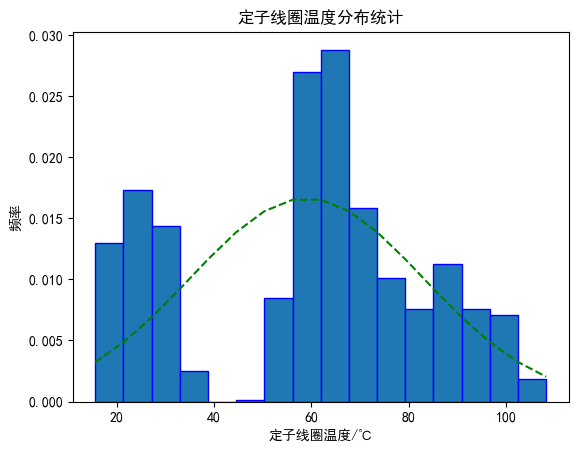

In [58]:
temp_data = final_data.iloc[:,1]
mu = np.mean(temp_data)
sigma = np.std(temp_data)
n, bins, patches = plt.hist(temp_data, bins=16, edgecolor="b", density=True)
y = norm.pdf(bins, mu, sigma) #拟合一条最佳正态分布曲线y
plt.plot(bins, y, 'g--') #绘制y的曲线
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度/℃")
plt.ylabel("频率")
plt.savefig("../image/最终温度分布直方图.png", dpi=600)
plt.show()

# 分位数

In [59]:
temp_data = final_data.iloc[:,1]

In [93]:
temp_data.mean()

59.05969696969696

In [94]:
temp_data.quantile([0.25,0.5,0.75])

0.25    32.120
0.50    62.685
0.75    74.915
Name: 1, dtype: float64